In [1]:
import os
import sys
import time
from tqdm.notebook import tqdm
import itertools
from IPython.display import display, Latex

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['figure.max_open_warning'] = 40
sns.set_style('whitegrid')

Сгенерируем выборку для обучения на ней градиентного бустинга

In [142]:
np.random.seed(14)
X = np.zeros((0, 2))

tmp = np.random.multivariate_normal(mean=[1, 1], cov=np.array([
    [5, 3],
    [3, 5]
]), size=40)

X = np.vstack((
    X, tmp
))

tmp = np.random.multivariate_normal(mean=[20, 20], cov=np.array([
    [1, 10],
    [10, 1]
]), size=40)

X = np.vstack((
    X, tmp
))

tmp = np.random.multivariate_normal(mean=[35, -30], cov=np.array([
    [10, 8],
    [8, 10]
]), size=40)

X = np.vstack((
    X, tmp
))

tmp = np.random.multivariate_normal(mean=[50, 20], cov=np.array([
    [1, 0],
    [0, 1]
]), size=40)

X = np.vstack((
    X, tmp
))

x_dom = np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 200)

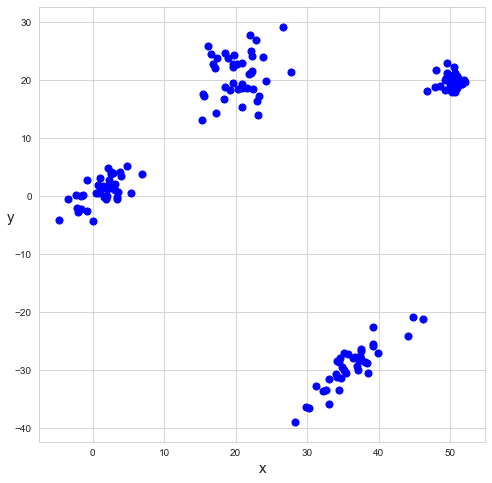

In [89]:
plt.scatter(X[:, 0], X[:, 1], color='blue', s=50);
plt.xlabel('x', fontsize=15);
plt.ylabel('y', fontsize=15, rotation=0);

#### Бустинг

$a_{N}(x) = \sum\limits_{j=1}^N b_{j}(x), \ b_{N} = arg\min\limits_{b_{N}} \frac{1}{n}\sum\limits_{i=1}^nL(y, a_{N-1}(x_{i}) + b_{N}(x_{i}))$

Пусть $L(y, z) = (y - z)^2, $ а базовые алгоритмы $(b_{j}(x))$ возьмём в классе линейных регрессий

In [90]:
models_dict = {} # в этот словарь будем сохранять модели

##### 0 шаг

$a_{N}(x) = b_{0}(x)$

$b_{0}(x) = \bar y$

In [91]:
models_dict['b_0'] = {'split': X[:, 0].min()-1, 'y_left': -1, 'y_right': X[:, 1].mean()}


In [92]:
predictions_0 = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] else models_dict['b_0']['y_right']  
                          for x in X[:, 0]])
prediction_0_for_picture = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] else models_dict['b_0']['y_right']  
                          for x in x_dom])
s_1 = X[:, 1] - predictions_0

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, prediction_0_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_1);

##### 1 шаг

$a_{N}(x) = b_{0}(x) + b_{1}(x) \Rightarrow a_{N-1}(x) = b_{0}(x)$

$b_{1}(x) = arg\min\limits_{b_{1}} \frac{1}{n} \sum\limits_{i=1}^n (\underbrace{y_{i} - a_{N-1}(x_{i})}_{s_{i}^(1)} - b_{1}(x_{i}))^2 \Rightarrow b_{1}(x) = arg\min \frac{1}{n} \sum\limits_{i=1}^n (b_{1}(x_{i}) - s_{i}^{(1)})^2$ 

Но $b_{1}(x)$ - это алгоритм из определённого класса - из класса решающих пней, а значит:

$b_{1}(x) = arg\min\limits_{t, y_{left}, y_{right}} \frac{1}{n}\sum\limits_{i=1}^n ( y_{left} \cdot [x_{i} < t] + y_{right} \cdot [x_{i} \ge t]  - s_{i}^{(1)} )^2$

In [94]:
def variance_criterion(split: float, y: np.array, x: np.array) -> float:
    """
    Args:
        split: вещественное число по которому проводить разбиение на левый и правый листья
        y: значения переменной, для которой проводить разбиение
        x: значения переменной, по которой проводить разбиения
    Return:
        Взвешенное значение дисперсии в подлистьях
    """
    y_left = y[x < split]
    y_right = y[x >= split]
    
    return (len(y_left)/len(y))*y_left.var() + (len(y_right)/len(y))*y_right.var()
    

def split_leaf(x: np.array, y: np.array) -> float:
    """
    Args:
        x: признак, по которому необходимо найти оптимальное разбиение
        y: таргет, на основе которого искать оптимальное разбиение
    Return:
                                                       [x < t]
        1) оптимальное значение t разбиения листа      /     \
                                                     ...     ...
        2) оптимальное значение в левом дочернем листе
        3) оптимальное значение в правом дочернем листе
    """

    unq_split_values = sorted(list(set(x)))
    unq_split_values = np.array([(i + j)/2 for i, j in zip(unq_split_values, unq_split_values[1:])])
    best_split = None
    best_variance = None
    for split in unq_split_values:
        current_variance = variance_criterion(split=split, y=y, x=x)
        if best_split is None:
            best_variance = current_variance
            best_split = split
        else:
            if current_variance < best_variance:
                best_split = split
                best_variance = current_variance
    y_left = y[x < best_split].mean()
    y_right = y[x >= best_split].mean()
    return best_split, y_left, y_right


In [95]:
# Находим оптимальный пень b1
t, y_l, y_r = split_leaf(x=X[:, 0], y=s_1)
print(t, y_l, y_r)

46.512474702383265 -5.588702106722146 16.766106320166433


Отсюда получаем, что $b_{1}(x) = 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] $

$a_{N}(x) = b_{0}(x) + b_{1}(x) = 3.15 + 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] $

In [98]:
# Добавляем его в a_N(x)
models_dict['b_1'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

In [99]:
predictions_1 = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in X[:, 0]]
)

s_2 = X[:, 1] - predictions_1

predictions_1_for_picture = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in x_dom]
)


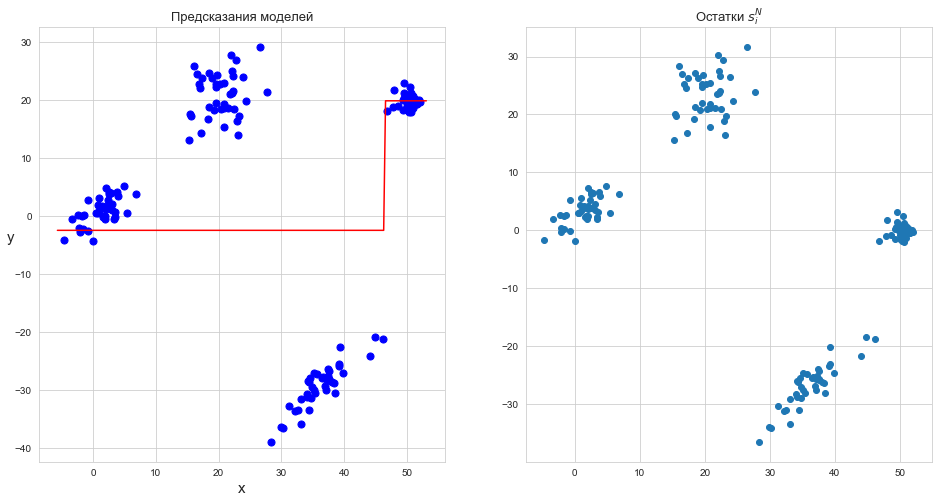

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_1_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_2);

##### 2 шаг

In [101]:
# Находим оптимальный пень b2
t, y_l, y_r = split_leaf(x=X[:, 0], y=s_2)
print(t, y_l, y_r)

28.058999617998005 13.412145822226284 -13.412145822226282


In [102]:
# Добавляем его в a_N(x)
models_dict['b_2'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

$b_{2}(x) = 12.3 \cdot [x < 28.06] - 12.52 \cdot [x \ge 28.06] $

$a_{N}(x) = b_{0}(x) + b_{1}(x) + b_{2}(x) = 3.15 + 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] + 13.41 \cdot [x < 28.06] - 13.41 \cdot [x \ge 28.06] $

In [103]:
predictions_2 = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in X[:, 0]]
)

s_3 = X[:, 1] - predictions_2

predictions_2_for_picture = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in x_dom]
)

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_2_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_3);

##### 3 шаг

In [105]:
# Находим оптимальный пень b3
t, y_l, y_r = split_leaf(x=X[:, 0], y=s_3)
print(t, y_l, y_r)

46.512474702383265 -4.4707152740754275 13.412145822226284


In [106]:
# Добавляем его в a_N(x)
models_dict['b_3'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

$b_{3}(x) = 13.41 \cdot [x \ge 46.51] - 4.47 \cdot [x < 46.51] $

$a_{N}(x) = b_{0}(x) + b_{1}(x) + b_{2}(x) + b_{3}(x) = 3.15 + 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] + 13.41 \cdot [x < 28.06] - 13.41 \cdot [x \ge 28.06] + 13.41 \cdot [x \ge 46.51] - 4.47 \cdot [x < 46.51]$

In [108]:
predictions_3 = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in X[:, 0]]
)

s_4 = X[:, 1] - predictions_3

predictions_3_for_picture = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in x_dom]
)

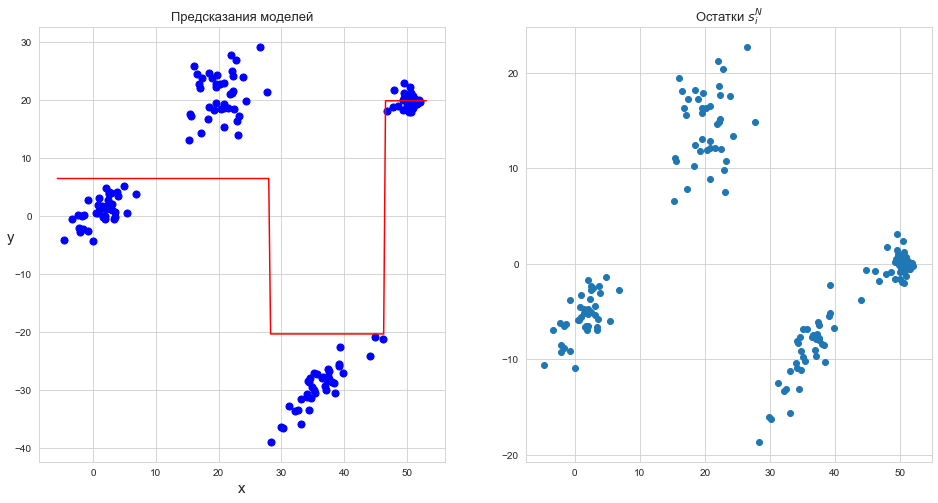

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_3_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_4);

##### Итоговый прогноз для различной длины (N) композиции

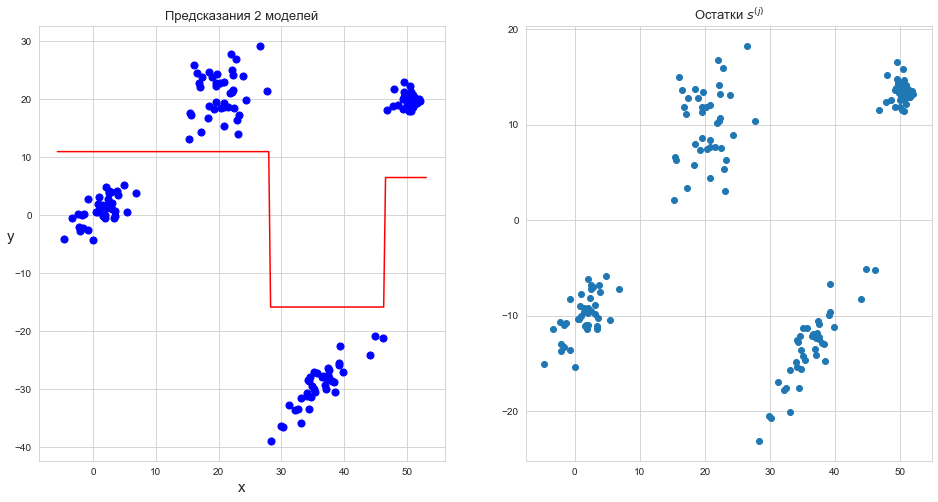

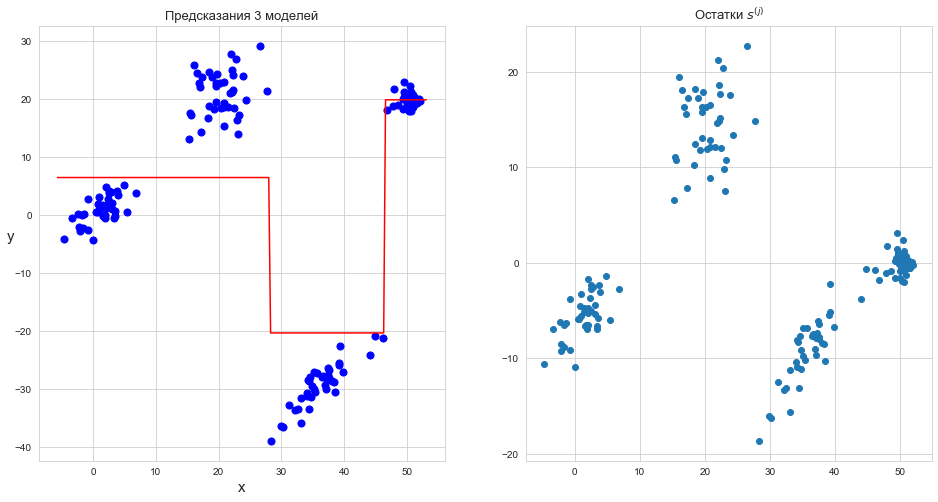

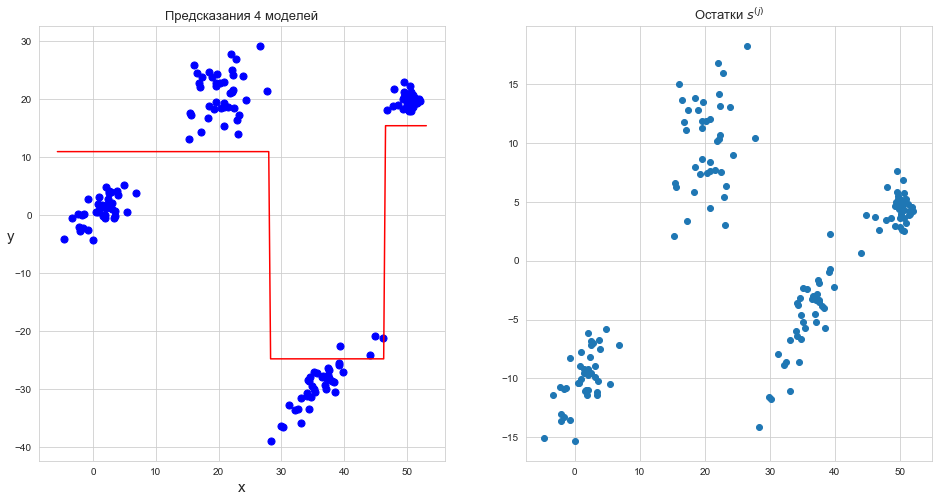

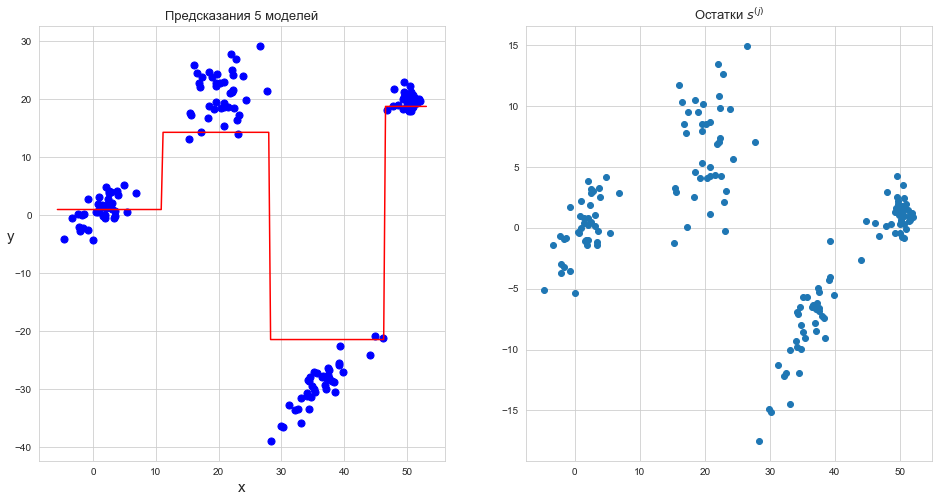

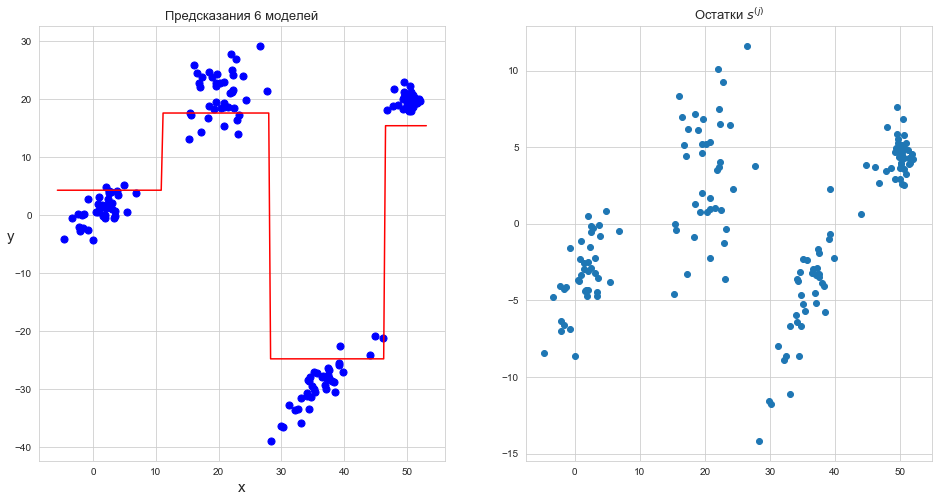

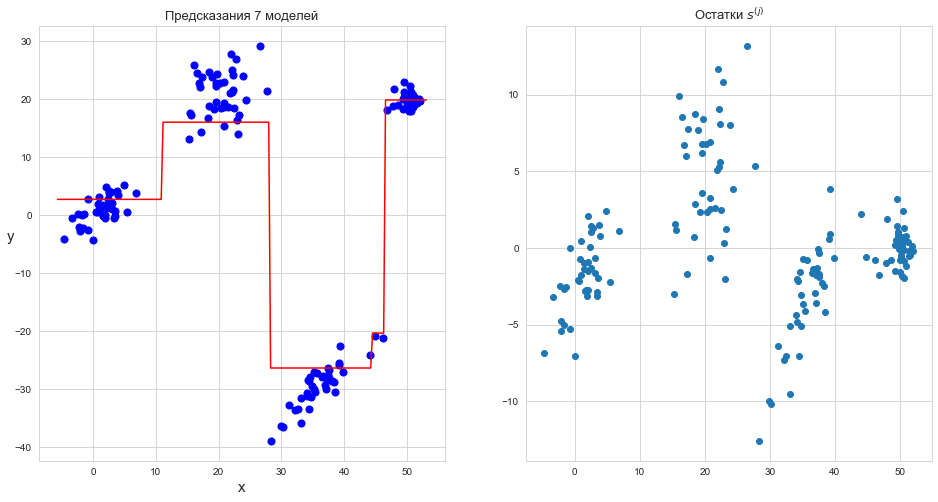

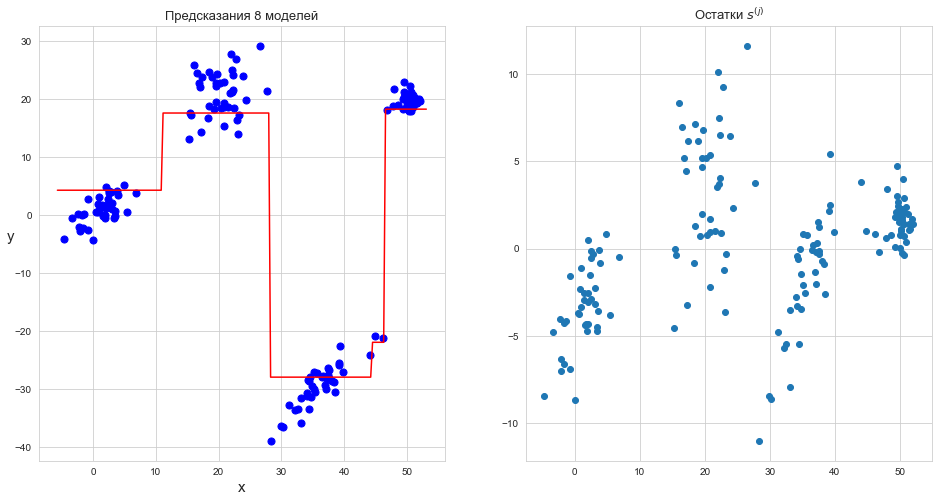

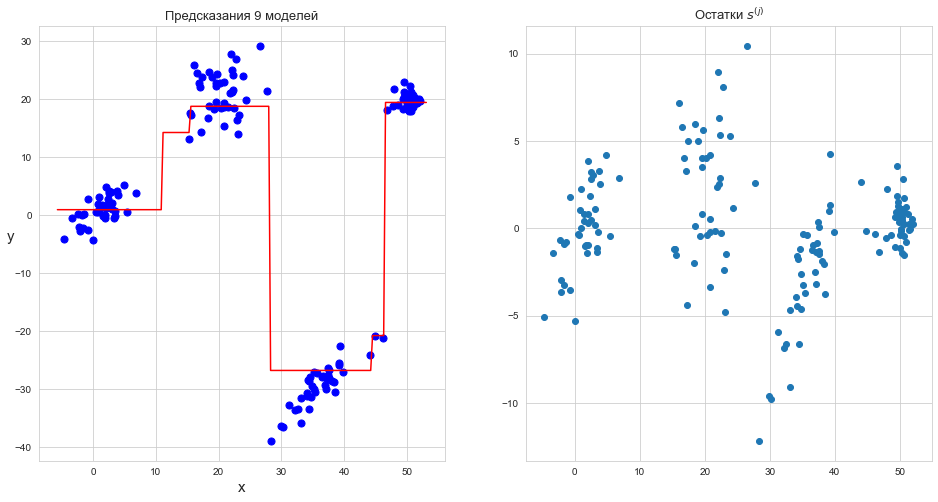

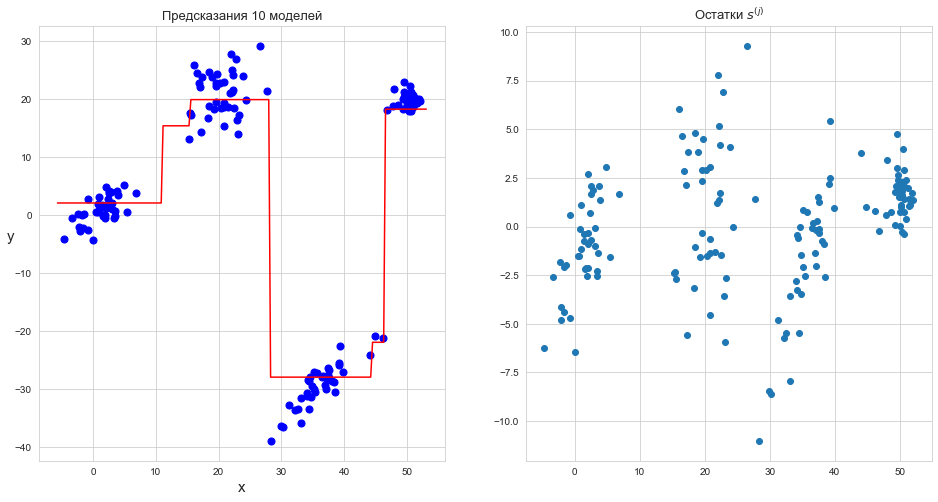

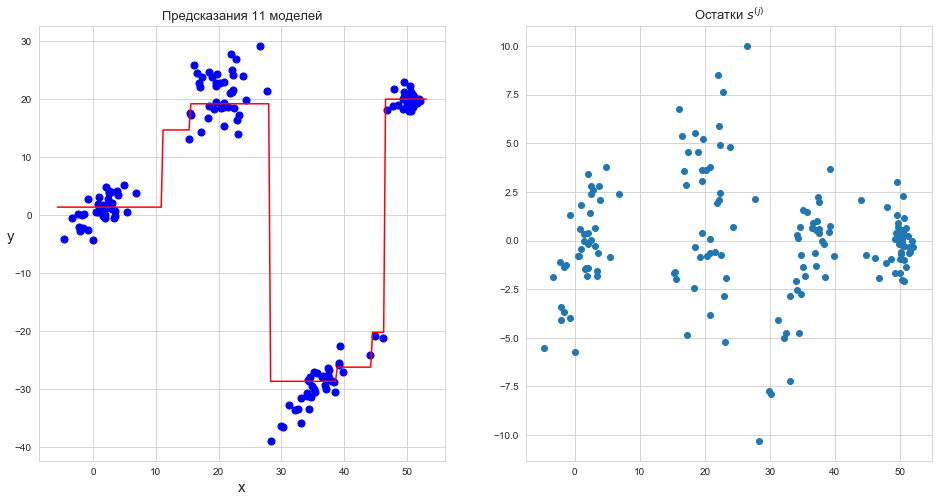

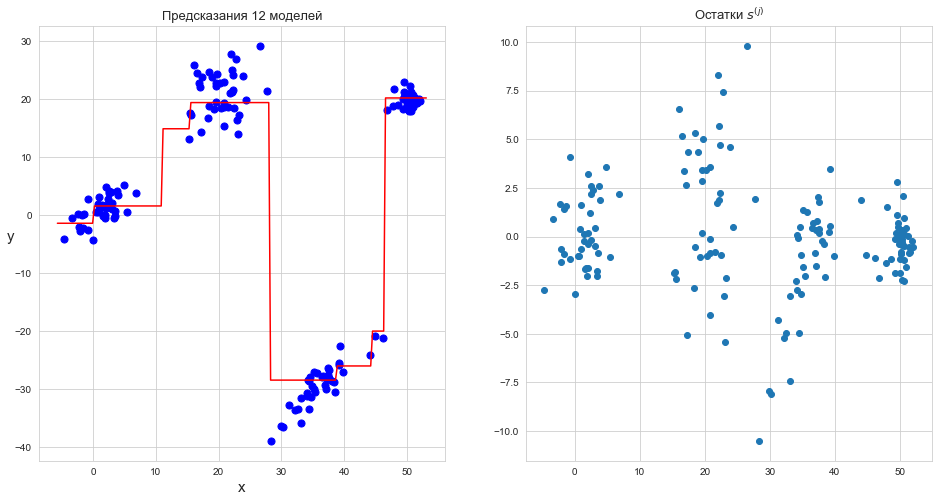

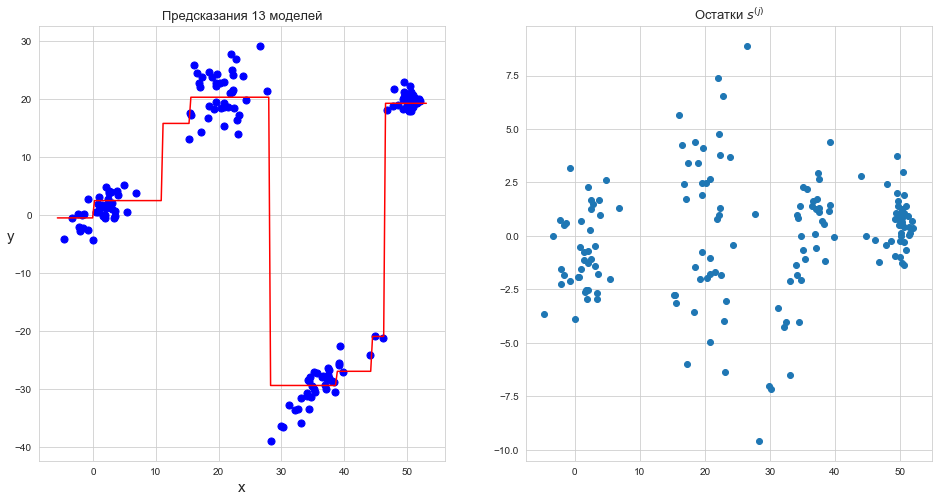

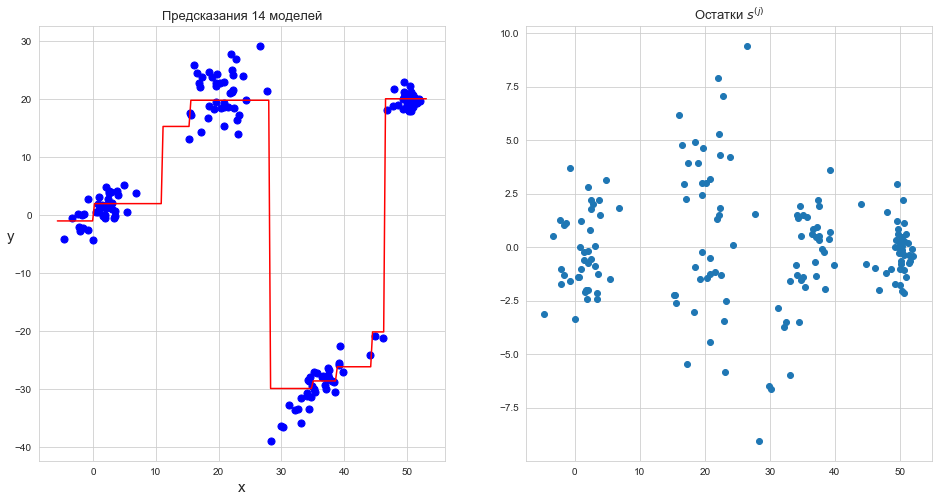

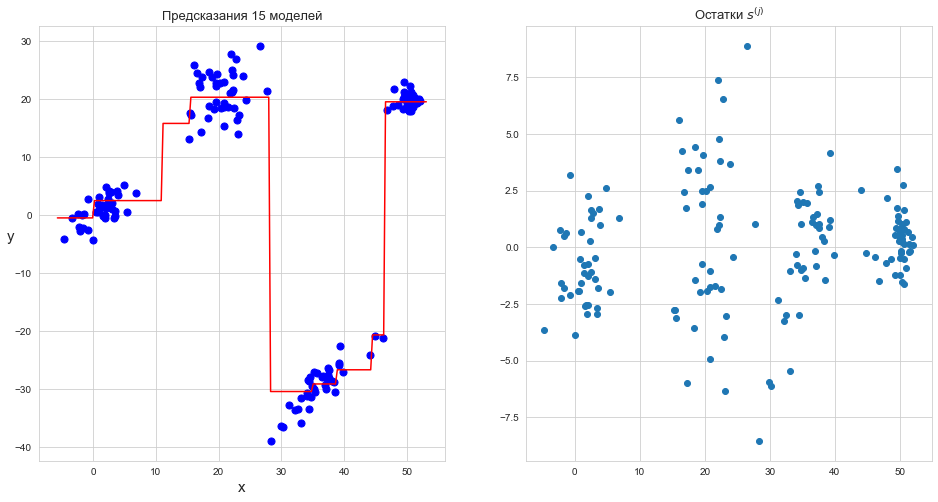

In [134]:
N = 15
models_dict = {}
hist_residuals = []
models_dict['b_0'] = {'split': X[:, 0].min()-1, 'y_left': -1, 'y_right': X[:, 1].mean()}

predictions = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] 
                        else models_dict['b_0']['y_right']  
                          for x in X[:, 0]])
predictions_for_picture = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] 
                                    else models_dict['b_0']['y_right']  
                          for x in x_dom])
s_j = X[:, 1] - predictions
hist_residuals.append((s_j**2).sum())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(f'Остатки $s^{{(j)}}$', fontsize=13);
ax[1].scatter(X[:, 0], s_j);

for j in range(1, N+1):
    # Находим оптимальный пень bj
    t, y_l, y_r = split_leaf(x=X[:, 0], y=s_j)
    
    # Добавляем его в a_N(x)
    models_dict[f'b_{j}'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

    predictions = np.array(
        [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] 
              else models_dict[f'b_{j}']['y_right'] 
              for j in range(len(models_dict))]) for x in X[:, 0]]
    )

    s_j = X[:, 1] - predictions
    hist_residuals.append((s_j**2).sum())

    predictions_for_picture = np.array(
        [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] 
              else models_dict[f'b_{j}']['y_right'] 
              for j in range(len(models_dict))]) for x in x_dom]
    )

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax[0].set_title(f'Предсказания {j} моделей', fontsize=13)
    ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
    ax[0].plot(x_dom, predictions_for_picture, color='red')
    ax[0].set_xlabel('x', fontsize=15);
    ax[0].set_ylabel('y', fontsize=15, rotation=0);

    ax[1].set_title(f'Остатки $s^{{(j)}}$', fontsize=13);
    ax[1].scatter(X[:, 0], s_j);
    

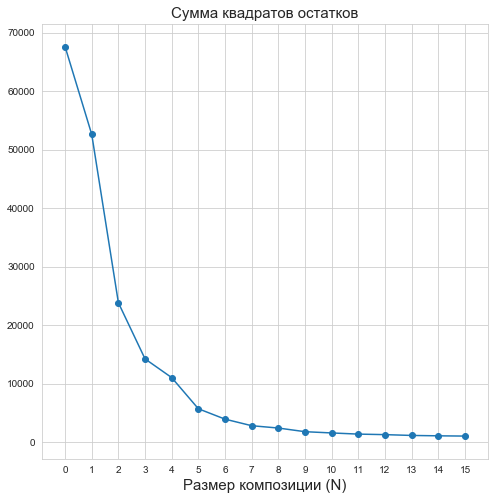

In [141]:
plt.title('Сумма квадратов остатков', fontsize=15);
plt.plot(hist_residuals);
plt.scatter(np.arange(len(hist_residuals)), hist_residuals);
plt.xlabel(f'Размер композиции (N)', fontsize=15)
plt.xticks(np.arange(N+1), np.arange(N+1));

### AdaBoost

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
y_ = (2*(y - 0.5)).astype(int)

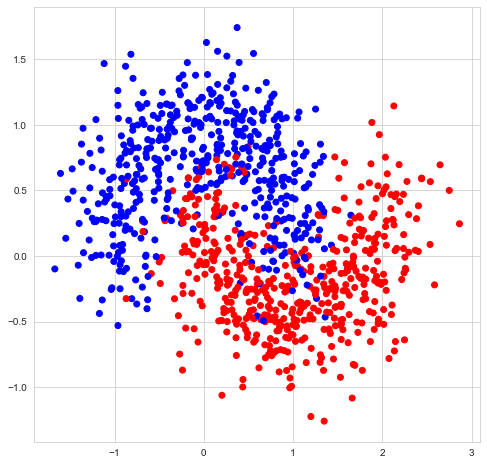

In [85]:
plt.scatter(X[:, 0], X[:, 1], color=np.array(['blue', 'red'])[y]);

In [352]:
def compute_n_misclassifications(target: np.array, predictions: np.array, weights: np.array) -> float:
    return np.sum( weights*(target*predictions < 0) )

def compute_criterion(feature_vector: np.array, target_vector: np.array, threshold: float, 
                      weights: np.array=None) -> (float, float, float):
    """
    Вычисляет, на сколько данное разбиение хорошо, с точки зрения критерия n_misclassifications
    """
    
    left_y = target_vector[feature_vector < threshold]
    right_y = target_vector[feature_vector >= threshold]
    N_root, N_left, N_right = len(target_vector), len(left_y), len(right_y)
    
    classes_root, root_probs = np.unique(target_vector, return_counts=True)
    root_probs = root_probs / root_probs.sum()
    classes_left, left_probs = np.unique(left_y, return_counts=True)
    left_probs = left_probs / left_probs.sum()
    classes_right, right_probs = np.unique(right_y, return_counts=True)
    right_probs = right_probs / right_probs.sum()
    
    root_class = classes_root[np.argmax(root_probs)]
    right_class = classes_right[np.argmax(right_probs)]
    left_class = classes_left[np.argmax(left_probs)]
    
    predictions = np.array(
        [left_class if val < threshold else right_class for val in feature_vector]
    )
    Q = compute_n_misclassifications(target=target_vector, predictions=predictions, weights=weights)
    return Q, left_class, right_class

class DecisionStumpClassifier(object):
    
    def __init__(self):
        self._stump = {}
        
    def fit(self, X: np.array, y: np.array, weights: np.array=None):
        best_misclass, best_threshold, best_feature_number, best_left_class, best_right_class = [None]*5
        for feature_number in range(X.shape[1]):
            feature_vector = X[:, feature_number]
            unq_vals = np.sort(np.unique(feature_vector))
            thresholds = np.array([(i + j)/2 for i, j in zip(unq_vals, unq_vals[1:])])
            for threshold in thresholds:
                misclass, left_class, right_class = compute_criterion(feature_vector=feature_vector, target_vector=y, 
                                                                  threshold=threshold, weights=weights)
                
                if best_misclass is None:
                    best_misclass = misclass
                    best_threshold = threshold
                    best_feature_number = feature_number
                    best_left_class = left_class
                    best_right_class = right_class
                if misclass < best_misclass:
                    best_misclass = misclass
                    best_threshold = threshold
                    best_feature_number = feature_number
                    best_left_class = left_class
                    best_right_class = right_class
                    
        self._stump['feature_number'] = best_feature_number
        self._stump['threshold'] = best_threshold
        self._stump['left_leaf'] = best_left_class
        self._stump['right_leaf'] = best_right_class
        return 
                
    def predict(self, X):
        assert self._stump != {}, 'Сначала обучите модель!'
        predictions = []
        for x in X:
            if x[self._stump['feature_number']] < self._stump['threshold']:
                predictions.append(self._stump['left_leaf'])
            else:
                predictions.append(self._stump['right_leaf'])
        return np.array(predictions)
    
    def decision_function(self):
        return fr"$[x_{self._stump['feature_number'] + 1} \le {round(self._stump['threshold'], 3)}] \cdot ({self._stump['left_leaf']}) + [x_{self._stump['feature_number'] + 1} \ge {round(self._stump['threshold'], 3)}] \cdot ({self._stump['right_leaf']})$"
    

In [353]:
stump = DecisionStumpClassifier()

In [354]:
stump.fit(X=X, y=y_, weights=np.array([1/X.shape[0]]*X.shape[0]))

In [355]:
stump._stump

{'feature_number': 1,
 'threshold': 0.24375679059596747,
 'left_leaf': 1,
 'right_leaf': -1}

In [357]:
display(Latex(stump.decision_function()))

<IPython.core.display.Latex object>

In [407]:
class AdaBoost(object):
    
    def __init__(self, N_base_models: int=10):
        self.N_base_models = N_base_models
        self._composition = {}
        
    def fit(self, X: np.array, y: np.array):
        # инициализируем веса
        weights = np.array([1/X.shape[0]]*X.shape[0])
        for model_number in tqdm(range(self.N_base_models)):
            # обучаем один базовый алгоритм
            base_t_model = DecisionStumpClassifier()
            base_t_model.fit(X=X, y=y, weights=weights)
            predictions = base_t_model.predict(X)
            # считаем для него число ошибок
            N_miscl = compute_n_misclassifications(target=y, predictions=predictions, weights=weights)
            # находим оптимальный вес данного алгоритма в композиции
            alpha_t = 0.5 * np.log((1 - N_miscl)/N_miscl)
            # пересчитываем веса объектов
            weights = weights * np.exp(-y*alpha_t*predictions)
            # нормируем веса объектов
            weights /= weights.sum()
            
            self._composition[model_number] = {'coef': alpha_t, 'model': base_t_model, 'weights': weights, 
                                               'error': N_miscl}
        return
    
    def predict(self, X: np.array) -> np.array:
        assert self._composition != {}, 'сначала обучите композицию!'
        
        predictions = np.zeros(X.shape[0])
        for model_number in range(self.N_base_models):
            predictions += \
                self._composition[model_number]['coef'] * self._composition[model_number]['model'].predict(X)
        return np.sign(predictions)
            
            

In [408]:
adaboost = AdaBoost(N_base_models=20)
adaboost.fit(X, y_)

In [451]:
k = 4
np.sum(adaboost._composition[k+1]['weights']*(adaboost._composition[k]['model'].predict(X)*y_ < 0))

0.3771674875538328

In [378]:
adaboost._composition

{0: {'coef': 0.7153167396825316,
  'model': <__main__.DecisionStumpClassifier at 0x1330133c8>,
  'weights': array([0.00259067, 0.00061958, 0.00061958, 0.00061958, 0.00061958,
         0.00061958, 0.00061958, 0.00259067, 0.00061958, 0.00061958,
         0.00061958, 0.00061958, 0.00061958, 0.00061958, 0.00061958,
         0.00061958, 0.00061958, 0.00061958, 0.00061958, 0.00061958,
         0.00061958, 0.00061958, 0.00061958, 0.00259067, 0.00061958,
         0.00061958, 0.00061958, 0.00259067, 0.00061958, 0.00259067,
         0.00061958, 0.00061958, 0.00061958, 0.00061958, 0.00259067,
         0.00061958, 0.00061958, 0.00061958, 0.00061958, 0.00259067,
         0.00061958, 0.00061958, 0.00061958, 0.00259067, 0.00061958,
         0.00061958, 0.00061958, 0.00061958, 0.00259067, 0.00061958,
         0.00061958, 0.00061958, 0.00061958, 0.00061958, 0.00061958,
         0.00259067, 0.00061958, 0.00259067, 0.00061958, 0.00061958,
         0.00061958, 0.00259067, 0.00061958, 0.00061958, 0.0006195

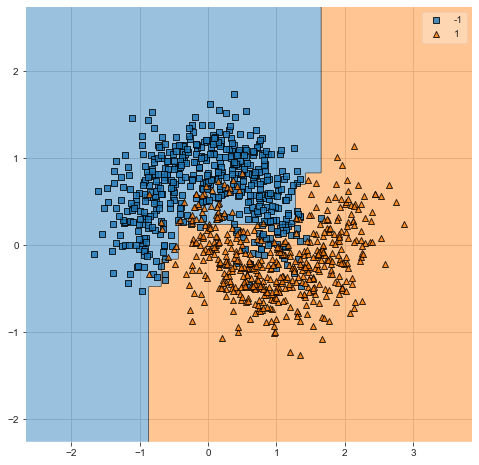

In [409]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X=X, y=y_, clf=adaboost);

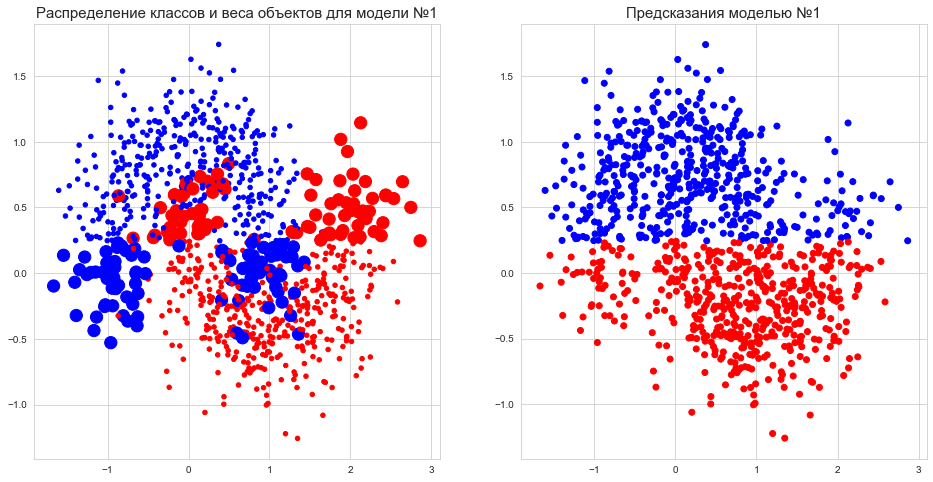

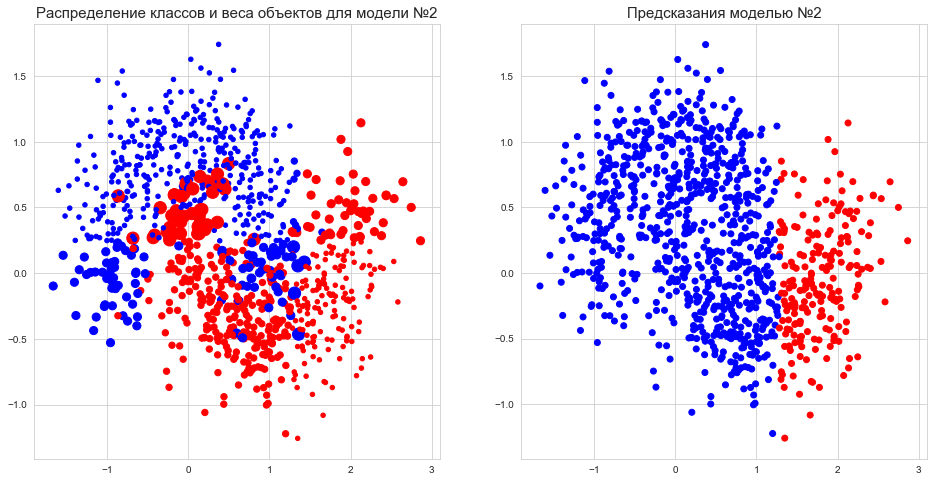

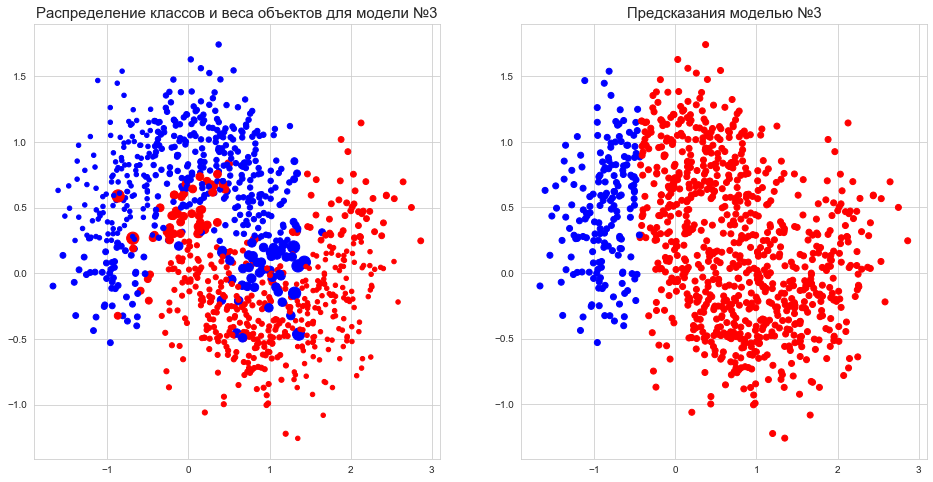

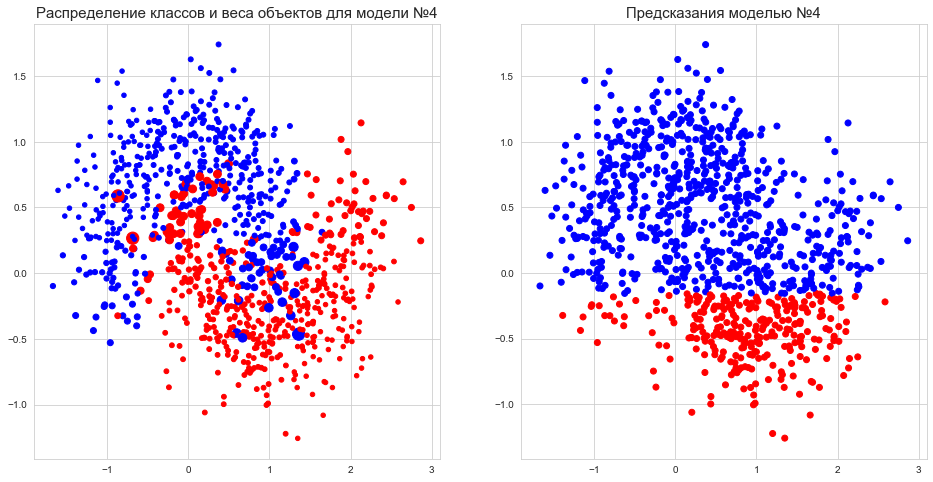

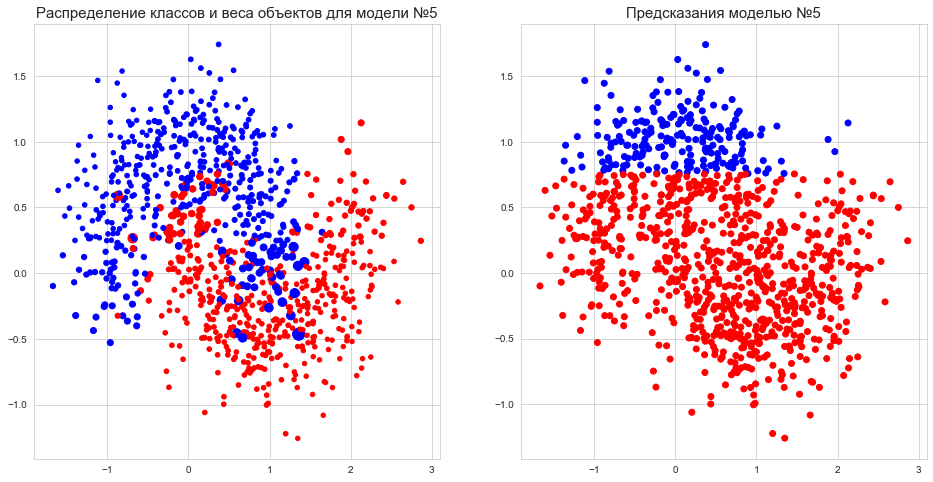

In [410]:
for k in range(5):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    weights = adaboost._composition[k]['weights']
    new_weights = (150 - 20)*(weights - weights.min())/(weights.max() - weights.min()) + 20
    predictions = adaboost._composition[k]['model'].predict(X)
    ax[0].set_title(f'Распределение классов и веса объектов для модели №{k+1}', fontsize=15)
    ax[0].scatter(X[:, 0], X[:, 1], color=np.array(['blue', 'red'])[y], s=new_weights);
    ax[1].set_title(f'Предсказания моделью №{k+1}', fontsize=15)
    ax[1].scatter(X[:, 0], X[:, 1], color=np.array(['blue', 'red'])[(predictions > 0).astype(int)]);
    plt.show();

In [411]:
from sklearn.metrics import accuracy_score
accuracy = []
for n_models in tqdm(range(len(adaboost._composition))):
    predictions = np.zeros(X.shape[0])
    for n, (coef, base_model) in enumerate(adaboost._composition.items()):
        if n == n_models + 1:
            break
        predictions += adaboost._composition[n]['coef'] * adaboost._composition[n]['model'].predict(X)
    predictions = np.sign(predictions)
    accuracy.append(
        accuracy_score(y_true=y, y_pred=(predictions > 0).astype(int))
    )

In [413]:
plt.title(f'Зависимость качества от размера композиции', fontsize=19);
plt.plot(np.arange(len(accuracy)), accuracy);
plt.scatter(np.arange(len(accuracy)), accuracy);
plt.xticks(np.arange(len(accuracy)), 1+np.arange(len(accuracy)));
plt.xlabel(f'Размер композиции', fontsize=15);
plt.ylabel('Точность', fontsize=15);

In [443]:
# Вид итоговой композиции
res = ''
for k in range(len(adaboost._composition)):
    res += f"{round(adaboost._composition[k]['coef'], 3)} \cdot \left( {adaboost._composition[k]['model'].decision_function().replace('$', '')} \\right) +"
res = res[:-1]
display(Latex(
    f'$sign \left( {res} \\right)$'
))
              

<IPython.core.display.Latex object>

## Tree Gradient Boosting

In [392]:
def sigma(z): return 1 / (1 + np.exp(-z))


class MSELoss(object):
    
    def __call__(self, y_true: np.array, y_pred: np.array) -> float:    
        return np.sum((y_true - y_pred)**2)
    
    def grad(self, y_true: np.array, y_pred: np.array) -> np.array:
        return -(y_true - y_pred)
    
    def optimal_leaf_constant(self, y_true: np.array, prev_ensemble_pred: np.array) -> float:
        return np.mean((y_true - prev_ensemble_pred))
    
    
class MAELoss(object):
    
    def __call__(self, y_true: np.array, y_pred: np.array) -> float:    
        return np.sum(np.abs(y_true - y_pred))
    
    def grad(self, y_true: np.array, y_pred: np.array) -> np.array:
        return -np.sign(y_true - y_pred) 
    
    def optimal_leaf_constant(self, y_true: np.array, prev_ensemble_pred: np.array) -> float:
        return np.median((y_true - prev_ensemble_pred))
    
    
class LogisticLoss(object):
    
    def __call__(self, y_true: np.array, y_pred: np.array) -> float:    
        return np.sum(np.log(1 + np.exp(-y_true * y_pred)))
    
    def grad(self, y_true: np.array, y_pred: np.array) -> np.array:
        return -y_true * sigma(-y_true * y_pred)
    
    def optimal_leaf_constant(self, y_true: np.array, prev_ensemble_pred: np.array) -> float:
        pass

In [504]:
loss = LogisticLoss()

In [505]:
# loss(y_true=np.array([1, 1, 1, 2]), y_pred=np.array([1, 0, 0, 5]))
loss(y_true=np.array([1, 1, -1, -1]), y_pred=np.array([15, 83, -100, 10]))

2.500011426200373

In [507]:
loss.grad(y_true=np.array([1, 1, -1, -1]), y_pred=np.array([15, 83, -100, 10]))

array([-7.64755567e-08, -2.24645649e-37,  9.30018994e-45,  2.49988651e-01])

In [514]:
class GradientBoosting(object):
    
    def __init__(self, loss: callable, base_model: object, n_estimators: int=10):
        self.loss = loss
        self.base_model = base_model
        self.n_estimators = n_estimators
        self._composition = {}
        
    def fit(self, X, y):
        

In [6]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text

Для примера обучим градиентный бустинг над решающими пнями с функцией потерь MAE

In [331]:
def predict_with_composition(composition: dict, X: np.array, task: str='regression') -> np.array:
    
    assert task in ['regression', 'classification'], "task может быть 'regression' или 'classification'!"
        
    predictions = np.zeros(X.shape[0])
    if task == 'regression':
        for model_number, base_model in composition.items():
            if len(X.shape) > 1:
                predictions += base_model.predict(X)
            elif len(X.shape) == 1:
                predictions += base_model.predict(X.reshape(-1, 1))
            else:
                assert False, 'X должен быть быть не пустым'
    else:
        for model_number, base_model in composition.items():
            if len(X.shape) > 1:
                predictions += base_model.predict(X)
            elif len(X.shape) == 1:
                predictions += base_model.predict(X.reshape(-1, 1))
            else:
                assert False, 'X должен быть быть не пустым'
        predictions = sigma(predictions)
    return np.array(predictions)

#### Задача регрессии

In [332]:
# Генерируем выборку:
N = 1000
X = np.random.uniform(-8, 8, size=(N, 1))
x_dom = np.linspace(X.ravel().min(), X.ravel().max(), 500)
y = np.sin(X.ravel()) + np.random.normal(scale=0.3, size=N)

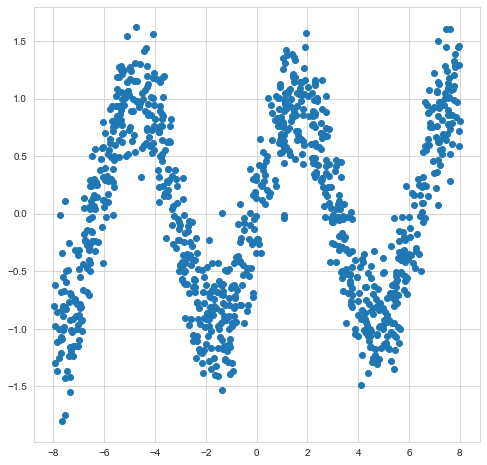

In [333]:
plt.scatter(X.ravel(), y);

Обучаем 1yю базовую модель...


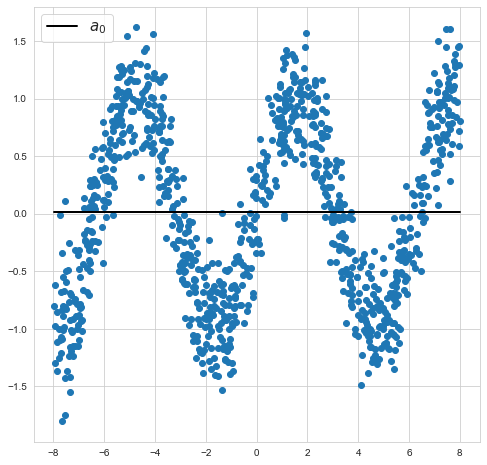

Обучаем 2yю базовую модель...


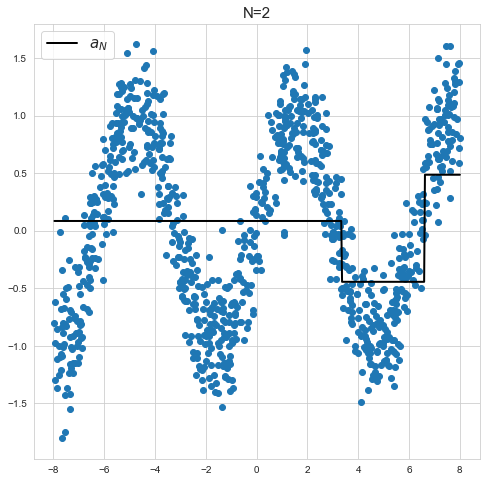

Обучаем 3yю базовую модель...


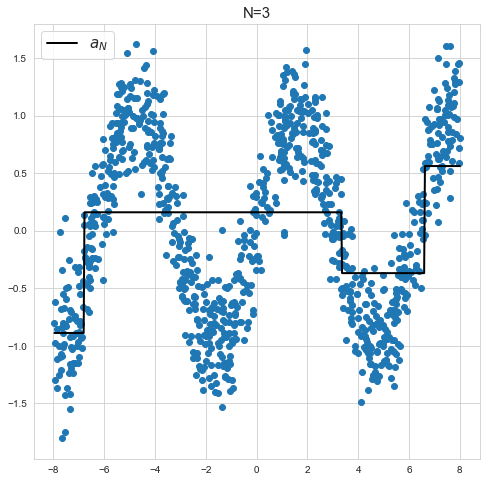

Обучаем 4yю базовую модель...


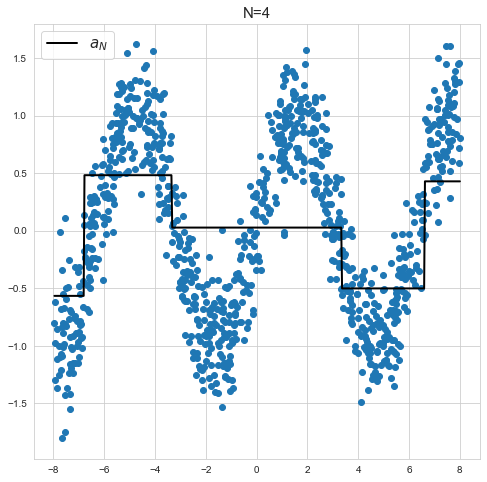

Обучаем 5yю базовую модель...


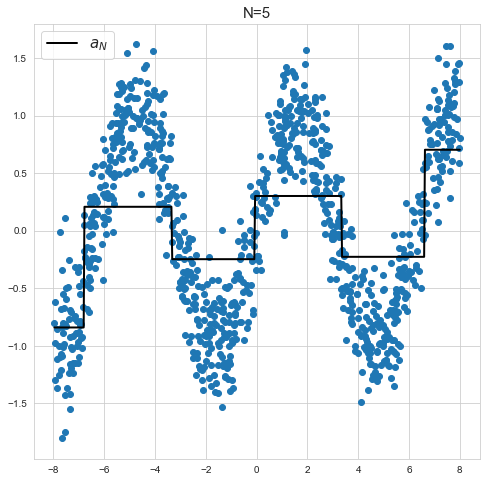

Обучаем 6yю базовую модель...


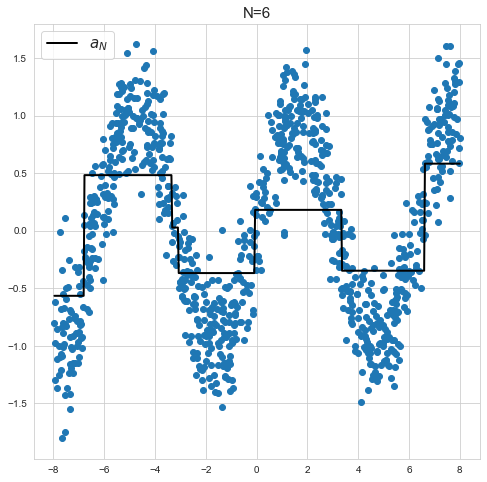

Обучаем 7yю базовую модель...


Обучаем 8yю базовую модель...


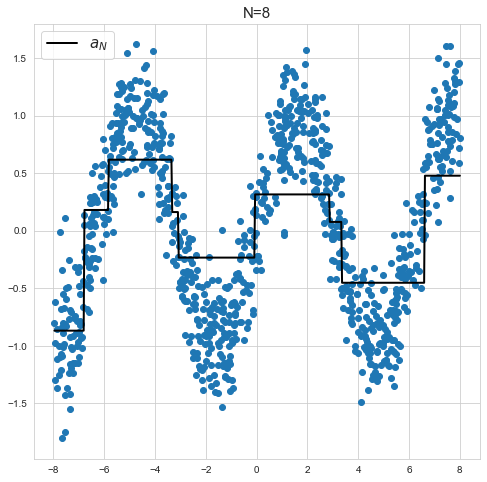

Обучаем 9yю базовую модель...


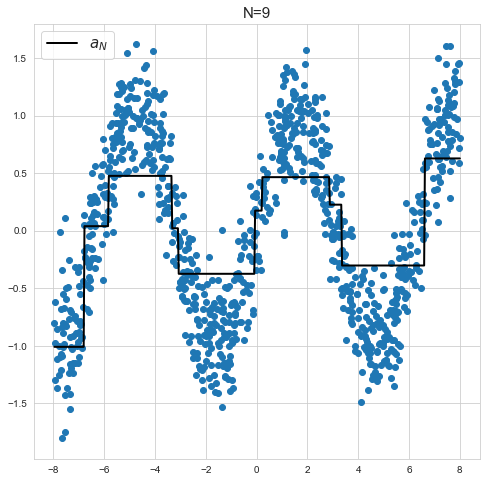

Обучаем 10yю базовую модель...


Обучаем 11yю базовую модель...


Обучаем 12yю базовую модель...


Обучаем 13yю базовую модель...


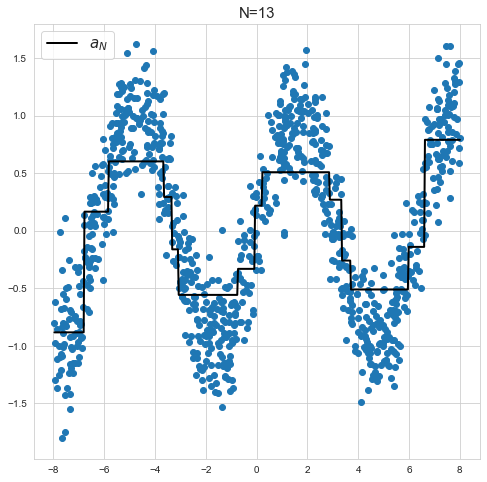

Обучаем 14yю базовую модель...


Обучаем 15yю базовую модель...


In [335]:
N = 0 # номер базовой модели
composition = {}
base_model_0 = DecisionTreeRegressor(max_depth=1, criterion='mse')
base_model_0.fit(X, y)
# Заменяем ответы в листьях ---------------------------------------------
for i in range(base_model_0.tree_.value.shape[0]):
    base_model_0.tree_.value[i] = np.array([[np.mean(y)]])
#------------------------------------------------------------------------
composition[N] = base_model_0
loss = MSELoss()
# loss = MAELoss()
# loss = LogisticLoss()

plt.figure(figsize=(8, 8));
plt.scatter(X.ravel(), y);
plt.plot(x_dom, base_model_0.predict(x_dom.reshape(-1, 1)), linewidth=2, color='black', label=r'$a_{0}$');
plt.legend(fontsize=15);

for N in range(1, 15+1):
    print(f'Обучаем {N}yю базовую модель...')
    base_model = DecisionTreeRegressor(max_depth=1, criterion='mse')
    base_model.fit(X=X, 
                     y=-loss.grad(y_true=y, y_pred=predict_with_composition(composition=composition, X=X)))
    composition[N] = base_model

    plt.figure(figsize=(8, 8));
    plt.title(f'N={N}', fontsize=15);
    plt.scatter(X.ravel(), y);
    plt.plot(x_dom, predict_with_composition(composition=composition, X=x_dom.reshape(-1, 1)), 
             linewidth=2, color='black', label=r'$a_N$');
    plt.legend(fontsize=15);
    plt.show();

#### Задача Классификации

In [539]:
X, y = make_moons(n_samples=1000, noise=0.35, random_state=443)

In [540]:
plt.scatter(X[:, 0], X[:, 1], color=np.array(['dodgerblue', 'red'])[y]);

In [541]:
from mlxtend.plotting import plot_decision_regions

In [585]:
def sigma(z): return 1 / (1 + np.exp(-z))

class GBTClassifier(object):
    
    def __init__(self, N_base_models: int=10, loss: object=LogisticLoss(), max_depth: int=1):
        self.composition = {}
        self.N_base_models = N_base_models
        self.loss = loss
        self.max_depth = max_depth
        
    def fit(self, X: np.array, y: np.array):
        
        y_ = y
        tmp_set = set(y)
        if 0 in tmp_set and -1 not in tmp_set:
            y_ = np.array([1 if val == 1 else -1 for val in y])
        
        # Обучаем нулевую базовую модель
        base_model_0 = DecisionTreeRegressor(max_depth=self.max_depth, criterion='mse')
        base_model_0.fit(X, y_)
        # Заменяем ответы в листьях ---------------------------------------------
        for i in range(base_model_0.tree_.value.shape[0]):
            base_model_0.tree_.value[i] = np.array([[np.mean(y_)]])
        #------------------------------------------------------------------------
        self.composition[0] = base_model_0
        
        # Обучаем последовательно N моделей
        for N in range(1, self.N_base_models+1):
            # считаем антиградиент функции потерь в точке ответов настроенной композиции
            current_antigrad = -self.loss.grad(
                y_true=y_, 
                y_pred=self.predict(X)
            )
            # Обучаем очередную базовую модель на антиградиенты
            base_model = DecisionTreeRegressor(max_depth=self.max_depth, criterion='mse')
            base_model.fit(X=X, y=current_antigrad)
            # Добавляем очередную модель в композицию
            self.composition[N] = base_model
    
    def predict(self, X: np.array) -> np.array:
        
        prediction = np.zeros(X.shape[0])
        for model_number, base_model in self.composition.items():
            prediction += base_model.predict(X)
        return sigma(prediction)

In [586]:
gbt_model = GBTClassifier(N_base_models=100, max_depth=1)
gbt_model.fit(X, y)

In [587]:
gbt_model.composition

{0: DecisionTreeRegressor(max_depth=1),
 1: DecisionTreeRegressor(max_depth=1),
 2: DecisionTreeRegressor(max_depth=1),
 3: DecisionTreeRegressor(max_depth=1),
 4: DecisionTreeRegressor(max_depth=1),
 5: DecisionTreeRegressor(max_depth=1),
 6: DecisionTreeRegressor(max_depth=1),
 7: DecisionTreeRegressor(max_depth=1),
 8: DecisionTreeRegressor(max_depth=1),
 9: DecisionTreeRegressor(max_depth=1),
 10: DecisionTreeRegressor(max_depth=1),
 11: DecisionTreeRegressor(max_depth=1),
 12: DecisionTreeRegressor(max_depth=1),
 13: DecisionTreeRegressor(max_depth=1),
 14: DecisionTreeRegressor(max_depth=1),
 15: DecisionTreeRegressor(max_depth=1),
 16: DecisionTreeRegressor(max_depth=1),
 17: DecisionTreeRegressor(max_depth=1),
 18: DecisionTreeRegressor(max_depth=1),
 19: DecisionTreeRegressor(max_depth=1),
 20: DecisionTreeRegressor(max_depth=1),
 21: DecisionTreeRegressor(max_depth=1),
 22: DecisionTreeRegressor(max_depth=1),
 23: DecisionTreeRegressor(max_depth=1),
 24: DecisionTreeRegressor

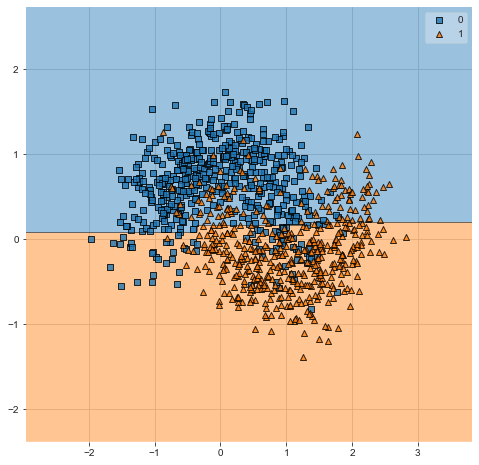

In [588]:
plot_decision_regions(clf=gbt_model, X=X, y=y)

In [589]:
metrics.accuracy_score(
    y_true=y,
    y_pred=(gbt_model.predict(X) > 0.5).astype(int)
)

0.797

In [594]:
composition = {}
max_depth = 1
y_ = y
tmp_set = set(y)
if 0 in tmp_set and -1 not in tmp_set:
    y_ = np.array([1 if val == 1 else -1 for val in y])

loss = LogisticLoss()    

# Обучаем нулевую базовую модель
base_model_0 = DecisionTreeRegressor(max_depth=max_depth, criterion='mse')
base_model_0.fit(X, y_)
# Заменяем ответы в листьях ---------------------------------------------
for i in range(base_model_0.tree_.value.shape[0]):
    base_model_0.tree_.value[i] = np.array([[np.mean(y_)]])
#------------------------------------------------------------------------
composition[0] = base_model_0

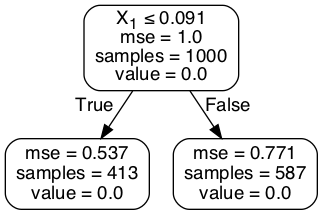

In [595]:
k = 0
dot_data = StringIO()
export_graphviz(composition[k], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [596]:
plot_decision_regions(clf=composition[0], X=X, y=y_);

//anaconda3/lib/python3.7/site-packages/mlxtend/plotting/decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


In [597]:
def predict_with_comp(composition: dict, X: np.array) -> np.array:
    prediction = np.zeros(X.shape[0])
    for model in composition.values():
        prediction += model.predict(X)
    return sigma(prediction)

# Просто класс для отображения предсказаний с помощью mlxtend
class TmpClass():

    def __init__(self, composition):
        self.composition = composition
    
    def predict(self, X):
        return (sigma(self.composition.predict(X)) > 0.5).astype(int)

In [ ]:
loss.grad

In [598]:
print(composition)
composition_predictions = predict_with_comp(composition=composition, X=X)

current_antigrad = -loss.grad(
    y_true=y_,
    y_pred=composition_predictions
)
print(current_antigrad[:10])

{0: DecisionTreeRegressor(max_depth=1)}
[-0.62245933  0.37754067  0.37754067  0.37754067  0.37754067 -0.62245933
  0.37754067  0.37754067 -0.62245933  0.37754067]


In [578]:
base_model = DecisionTreeRegressor(max_depth=max_depth, criterion='mse')
base_model.fit(X=X, y=current_antigrad)
# Добавляем очередную модель в композицию
composition[1] = base_model

In [579]:
k = 1
dot_data = StringIO()
export_graphviz(composition[k], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [580]:
k = 1
print(metrics.accuracy_score(
    y_true=y,
    y_pred=(sigma(composition[k].predict(X)) > 0.5).astype(int)
))

plot_decision_regions(clf=TmpClass(composition[k]), X=X, y=y);

0.873


In [581]:
print(composition)
composition_predictions = predict_with_comp(composition=composition, X=X)

current_antigrad = -loss.grad(
    y_true=y_,
    y_pred=composition_predictions
)
print(current_antigrad[:10])

{0: DecisionTreeRegressor(max_depth=2), 1: DecisionTreeRegressor(max_depth=2)}
[-0.59503888  0.3612113   0.3612113   0.3612113   0.36181389 -0.59503888
  0.36181389  0.36181389 -0.59503888  0.40496112]


In [582]:
base_model = DecisionTreeRegressor(max_depth=max_depth, criterion='mse')
base_model.fit(X=X, y=current_antigrad)
# Добавляем очередную модель в композицию
composition[2] = base_model

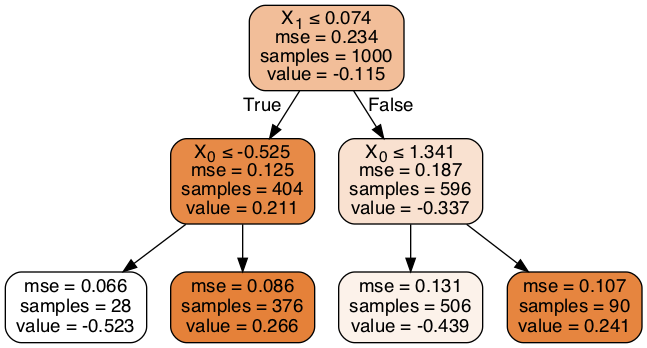

In [583]:
k = 2
dot_data = StringIO()
export_graphviz(composition[k], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [584]:
k = 2
print(metrics.accuracy_score(
    y_true=y,
    y_pred=(sigma(composition[k].predict(X)) > 0.5).astype(int)
))

plot_decision_regions(clf=TmpClass(composition[k]), X=X, y=y);

0.872


In [568]:
# predictions = np.zeros(X.shape[0])
# for model in composition.values():
#     print(model.predict(X)[:15])
#     predictions += model.predict(X)
# print('final predictions:')
# print(predictions[:15])